# Iterative Maximum Likelihood Estimation (iMLE)

## - Using the generalized Q function measurement

Shahnawaz Ahmed, Chalmers University of Technology, Sweden  
Email: shahnawaz.ahmed95gmail.com  
GitHub: quantshah

### Introduction

Quantum State Tomography is the process of determining an unknown quantum state by making measurements on the system and using the measurement data to reconstruct the density matrix of the state. In this notebook, we will use QuTiP for Quantum State Tomography of a cavity by counting photon number statistics (see [1, 2]). The data is from a "displace-and-measure" method on which we apply a statistical inference technique - iterative Maximum Likelihood Estimation [3] to reconstruct the full density matrix of a cat state.

We will reproduce approximately Fig 1 of Ref~[2].

## References
[1] Shahnawaz Ahmed, Carlos Sánchez Muñoz, Franco Nori, Anton Frisk Kockum. "Quantum State Tomography with Conditional Generative Adversarial Networks." https://arxiv.org/abs/2008.03240

[2] Shen, Chao, et al. "Optimized tomography of continuous variable systems using excitation counting." Physical Review A 94.5 (2016): 052327.  
Link: https://arxiv.org/abs/1606.07554

[3] Řeháček, J., Z. Hradil, and M. Ježek. "Iterative algorithm for reconstruction of entangled states." Physical Review A 63.4 (2001): 040303.

In [1]:
# imports 

import numpy as np

from qutip import Qobj, rand_dm, fidelity, displace, qdiags, qeye, expect
from qutip.states import coherent, coherent_dm, thermal_dm, fock_dm
from qutip.random_objects import rand_dm
from qutip.visualization import plot_wigner, hinton, plot_wigner_fock_distribution
from qutip.wigner import qfunc
import qutip

import matplotlib.pyplot as plt
from matplotlib import animation, colors


from IPython.display import clear_output

### Displacement operation

The measurements for determining cavity quantum states usually rely on finding the probability of observing a certain number of photons in the cavity, i.e., measuring the photon number operator (occupation) $|n \rangle  \langle n|$ after displacing the state by applying the displacement operator $$ D(\beta) = e^{\beta a^{\dagger} - \beta^*a}.$$

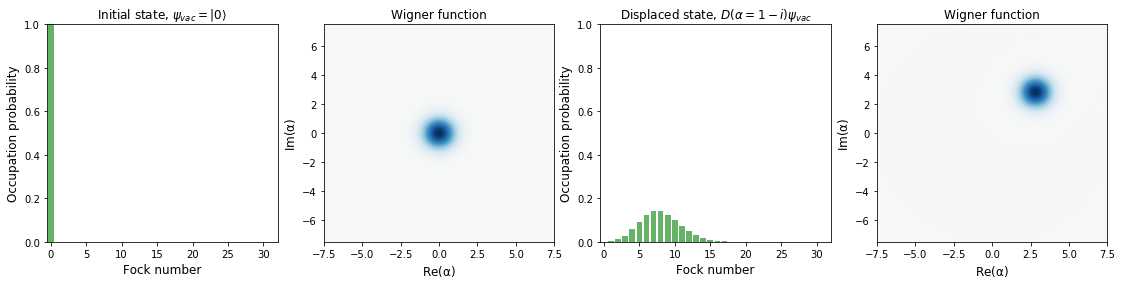

In [2]:
hilbert_size = 32

fig, ax = plt.subplots(1, 4, figsize=(19, 4))

plot_wigner_fock_distribution(coherent(hilbert_size, 0), fig=fig, axes=[ax[0], ax[1]])
plot_wigner_fock_distribution(displace(hilbert_size, 2+2j)*coherent(32, 0), fig=fig, axes=[ax[2], ax[3]])

ax[0].set_title(r"Initial state, $\psi_{vac} = |0 \rangle$")
ax[2].set_title(r"Displaced state, $D(\alpha=1-i )\psi_{vac}$")
plt.show()

### Optical quantum states in the fock basis

In the fock basis, we can describe optical quantum states as $|\psi \rangle = \sum_n^{N_{cut}}p_n |n \rangle$, where $N_{cut}$ is the photon number cutoff which truncates the Hilbert space and $|{p_n}|^2$ is the probability of observing $n$ photons. The vaccum state $\psi_{vac} = |0 \rangle$ or a superposition of fock states containing two and three photons $\psi_{fock} = \frac{1}{\sqrt{2}}(|2 \rangle + |3 \rangle$ are some examples of simple optical quantum states. The coherent state is a displaced fock state $\psi_{\texttt{coherent}(\alpha)} = D(\alpha) |0 \rangle$ and a superposition of two such coherent states is defined as a CAT state,  
$$\psi_{\texttt{CAT}(\alpha)} = \frac{\psi_{\texttt{coherent}}(\alpha) + \psi_{\texttt{coherent}}(-\alpha)}{\sqrt{2}}$$

### A superposition of three coherent states

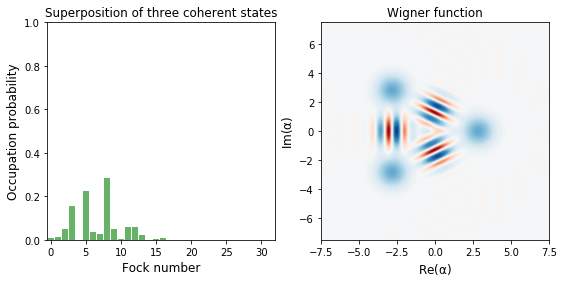

In [3]:
hilbert_size = 32
alpha_range = 2

alphas = np.array([alpha_range, -alpha_range - 1j*alpha_range,
                   -alpha_range + 1j*alpha_range])

psi = sum([coherent(hilbert_size, a) for a in alphas])
psi = psi.unit()
rho = psi*psi.dag()


fig, ax = plot_wigner_fock_distribution(rho, figsize=(9, 4))
ax[0].set_title("Superposition of three coherent states")
plt.show()

### Displace and measure - the generalized Q function

The expectation value of the photon number operators after applying a displacement $D(\beta_i)$ to the state density matrix $\rho = |\psi  \rangle \langle \psi|$ forms the so-called generalised $Q$ function:

$$Q_n^{\beta} = Tr[|n \rangle \langle n|D(-\beta) \rho D^\dagger(-\beta)$$

This type of "displace-and-measure" techniques can be seen as a generalization of some of the known observables in quantum optics, e.g., Husimi Q function (with some normalization N) $\frac{1}{N}Q_0^{\beta}$ which measures the vaccum state probability or the Wigner function which measures photon parity, $W(\beta) = \sum_n (-1)^n Q_n^{\beta}$.

# Data
We generate a CAT state and apply displacements $\beta_i$ (left) marked as x and record the diagonal elements of the density matrix to get all the occupation probabilities $|n \rangle \langle n|$. This is the same as measuring the expectation value of the displaced photon number operator on the state.

We can see $Q_n^{\beta}$ for various values of $Q_n^{\beta}$ (colored bar plots) which forms the data, $d_i$. The density matrix itself is shown as a hinton plot on the right. The size of the boxes in the hinton plot represent the magnitude of the density matrix element and the color reflects the absolute value being positive or negative.

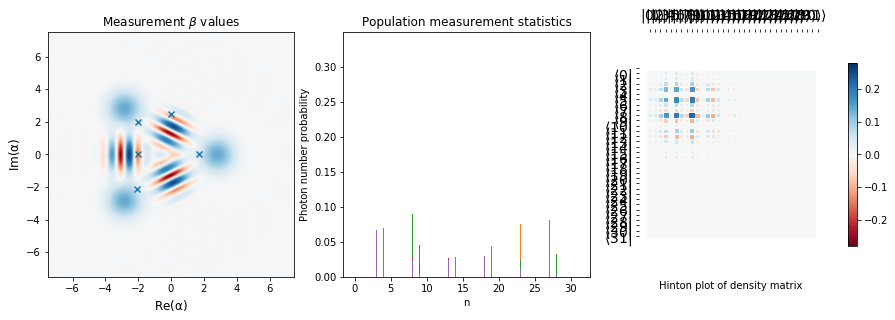

In [4]:
def random_alpha(radius, inner_radius=0):
    """
    Generates a random complex values within a circle
    
    Args:
        radius (float): Radius for the values
        inner_radius (float): Inner radius which defaults to 0.
    """
    radius = np.random.uniform(inner_radius, radius)
    phi = np.random.uniform(-np.pi, np.pi)
    return radius * np.exp(1j * phi)


def measure_q(beta, rho):
    """
    Measures the generalized q function values for the state density matrix.
    
    Parameters
    ----------    
    beta: np.complex
        A complex displacement.

    rho:
        The density matrix as a QuTiP Qobj (`qutip.Qobj`)

    Returns
    -------
    population: ndarray
        A 1D array for the probabilities for populations.
    """
    hilbertsize = rho.shape[0]
    # Apply a displacement to the state and then measure the diagonals.

    D = displace(hilbertsize, beta)
    rho_disp = D*rho*D.dag()
    
    # measure all the elements in the diagonal
    populations = np.real(np.diagonal(rho_disp.full()))
    return populations


betas = [1.7, -2, 2.5j, -2.1 - 2.1j, -2 + 2j]
generalized_Q = [measure_q(b, rho) for b in betas]


fig, ax = plt.subplots(1, 3, figsize=(15, 4.5))
indices = np.arange(hilbert_size)

plot_wigner(rho, fig, ax[0])
ax[0].scatter(np.real(betas), np.imag(betas), marker="x")
ax[0].set_title(r"Measurement $\beta$ values")

for i in range(len(betas)):
    ax[1].bar(indices, generalized_Q[i],
              label = r"$beta = {}$".format(i), width=(i+1)/100)

ax[1].set_title("Population measurement statistics")
ax[1].set_xlabel("n")
ax[1].set_ylabel("Photon number probability")

hinton(rho, ax=ax[2])
ax[2].set_xlabel("Hinton plot of density matrix")

plt.show()

### Iterative Maximum Likelihood Estimation

The measurement statistics from different measurement settings, i.e., values of displacements could be made informationally complete such that they contain the full information required to reconstruct the state, (see Ref [2]). Once we have the data, the iterative Maximum Likelihood Estimation (iMLE) method [3] can be used to start from a random guess of the density matrix and determine the full density matrix by repeatedly applying an operator $R$ to a randomly initialized density matrix.

$R$ is a sum of projection operators into the measured basis - the displaced photon number operator in this case, $M_i = D(\beta_i) |n \rangle \langle n|  D^{\dagger}(\beta_i)$. Each such operator is weighted by the ratio of observed frequency of the measurement (empirical probability from experimental data, $d_i$) and the estimate of the same from the density matrix, $Tr[M_i \rho]$

$$R = \sum_i \frac{d_i}{Tr[M_i \rho]} M_i$$

Then we iteratively apply $R$ as $R \rho R$ until convergence to get the density matrix from the measured data.

### Constructing the R operator from current estimate of the density matrix

In [5]:
def construct_R(hilbert_size, betas, ops=None):
    """
    Calculates the operators R in a displace and measure method.

    Parameters
    ----------
    hilbert_size (int):
        The hilbert space size
    beta: list_like
        A list of the displacements that were applied to the state before
        measurement.

    op: list of :class:`qutip.Qobj`
        Measurement operators such as photon occupation |n><n| that should
        be used to construct the R operator for various displacements.
        default: |n><n| constructed using `qutip.fock_dm(hilbert_size, n)`
                 for all n.

    Returns
    -------
    R: `qutip.Qobj`
        The iterative operator which we are going to apply for state
        reconstruction.
    """
    if ops == None:
        ops = []
        for n in range(hilbert_size):
            ops.append(fock_dm(hilbert_size, n))

    R_ops = []

    for beta in betas:
        D = displace(hilbert_size, beta)
        displaced_operators = []
        
        for operator in ops:
            displaced_D = D.dag()*operator*D
            displaced_operators.append(displaced_D)
        R_ops.append(displaced_operators)

    return R_ops


r_ops = construct_R(hilbert_size, betas)
expectation_values = [expect(r_ops[i], rho) for i in range(len(betas))]

# test if the expectation values calculated from the R operators match
# the previous calculations with the measure_q function
generalized_Q = [measure_q(b, rho) for b in betas]

print(np.allclose(expectation_values, generalized_Q))

True


### Reconstruction of the cat state density matrix from generalized $Q$ function measurements

In [6]:
r_ops = construct_R(hilbert_size, betas)
data = [expect(r_ops[i], rho) for i in range(len(betas))]


max_iter = 200

rho_reconstructed = rand_dm(hilbert_size) # Random initial dm
rho_t = []
rho_t.append(rho_reconstructed)

fidelities = [fidelity(rho_reconstructed, rho)]

for iterations in range(max_iter):
    R = 0*qeye(hilbert_size)

    for i in range(len(betas)):
        # for all the n photons 
        for n in range(hilbert_size):
            r = r_ops[i][n]
            R += (data[i][n]/(expect(r, rho_reconstructed) + 1e-20))*r

    rho_reconstructed = R*rho_reconstructed*R

    # Trace renorm
    rho_reconstructed = rho_reconstructed/rho_reconstructed.tr()
    rho_t.append(rho_reconstructed)

    # Compute fidelity
    f = fidelity(rho_reconstructed, rho)
    fidelities.append(f)

    print(r"Iteration {}; Fidelity: {}".format(iterations, f))
    clear_output(wait=True)

Iteration 199; Fidelity: 0.9919269486148575


# Let us plot the Husimi $Q$ function - Fig 1 of Ref~[2]

Note that due to the different scaling and normalizations adapted in QuTiP for setting hbar = $1$, we might need to change the scaling of our $\beta$ values to $\frac{Re[\beta] + i Im[\beta]}{\sqrt{2}}$ and use a prefactor $\frac{1}{2 \pi}$.

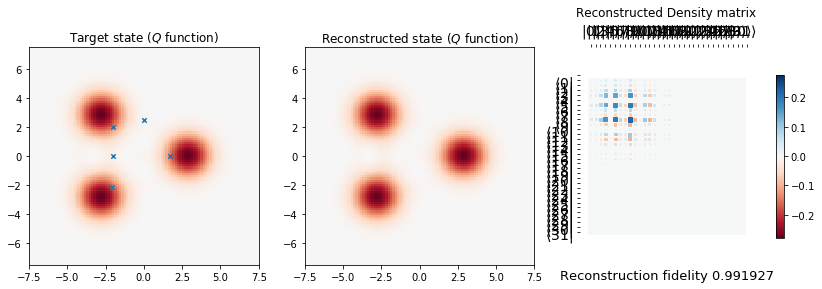

In [7]:
xvec = np.linspace(-7.5, 7.5, 100)
yvec = np.linspace(-7.5, 7.5, 100)

q_state = qfunc(rho, xvec, yvec)
q_reconstruction = qfunc(rho_reconstructed, xvec, yvec)

fig, ax = plt.subplots(1, 3, figsize=(14, 4))
norm = colors.DivergingNorm(vmin=-1e-9, vcenter=0, vmax=np.max(q_state))

ax[0].pcolor(xvec, yvec, q_state, norm=norm, cmap="RdBu_r")
ax[1].pcolor(xvec, yvec, q_reconstruction, norm=norm, cmap="RdBu_r")

hinton(rho_t[-1], ax=ax[2])
ax[0].scatter(np.real(betas), np.imag(betas), marker="x", s=20)

ax[0].set_title(r"Target state ($Q$ function)")
ax[1].set_title("Reconstructed state ($Q$ function)")
ax[2].set_title("Reconstructed Density matrix")
ax[2].set_xlabel("Reconstruction fidelity {:2f}".format(fidelity(rho_reconstructed, rho)), fontsize=13)

plt.show()

# QuTiP details

In [8]:
qutip.about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Current admin team: Alexander Pitchford, Paul D. Nation, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, and Boxi Li
Project Manager: Franco Nori.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      4.5.0.dev0+3421bc5c
Numpy Version:      1.18.5
Scipy Version:      1.5.0
Cython Version:     0.29.15
Matplotlib Version: 3.1.3
Python Version:     3.7.6
Number of CPUs:     6
BLAS Info:          Generic
OPENMP Installed:   False
INTEL MKL Ext:      False
Platform Info:      Darwin (x86_64)
Installation path:  /Users/shahnawaz/Dropbox/dev/qutip/qutip
Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qutip.cite()`
